### Standard RF Model with feature engineered data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import lime.lime_tabular
import shap
from IPython.display import display, HTML

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = '/Users/amalshar/Desktop/USD/Fall 2025/Data Analysis/Final Project/daily_2025_engineered_data.csv'
TARGET = 'DailyAQI'

# Base + Engineered Features
BASE_FEATURES = ['CO', 'SO2', 'NO2', 'O3', 'PM25', 'BarometricPressure', 'Temperature', 'WindResultant']
ENG_FEATURES = [
    'AQI_lag_1','AQI_lag_3','AQI_lag_7',
    'AQI_roll_3','AQI_roll_7',
    'CO_roll_3','CO_roll_7','NO2_roll_3','NO2_roll_7','PM25_roll_3','PM25_roll_7','O3_roll_3','O3_roll_7',
    'month','dayofweek','is_weekend','dayofyear',
    'PM25xTemp','NO2xWind'
]
FEATURES = BASE_FEATURES + ENG_FEATURES

In [3]:
df = pd.read_csv(DATA_PATH)
df['Date Local'] = pd.to_datetime(df['Date Local'])

# Clean and remove NAs in relevant columns
df = df.dropna(subset=FEATURES + [TARGET]).copy()

df = df.sort_values('Date Local')
dates_sorted = df['Date Local'].values
cut1 = np.quantile(dates_sorted, 0.70)
cut2 = np.quantile(dates_sorted, 0.80)

train_df = df[df['Date Local'] <= cut1]
val_df   = df[(df['Date Local'] > cut1) & (df['Date Local'] <= cut2)]
test_df  = df[df['Date Local'] > cut2]

print(f"Train/Val/Test sizes: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Val/Test sizes: 64291, 9124, 18325


In [4]:
X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val,   y_val   = val_df[FEATURES],   val_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [5]:
y_pred = rf_model.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-6))) * 100
r2   = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")


MSE: 58.986 | RMSE: 7.680 | MAE: 3.477 | MAPE: 25184.24% | R²: 0.926


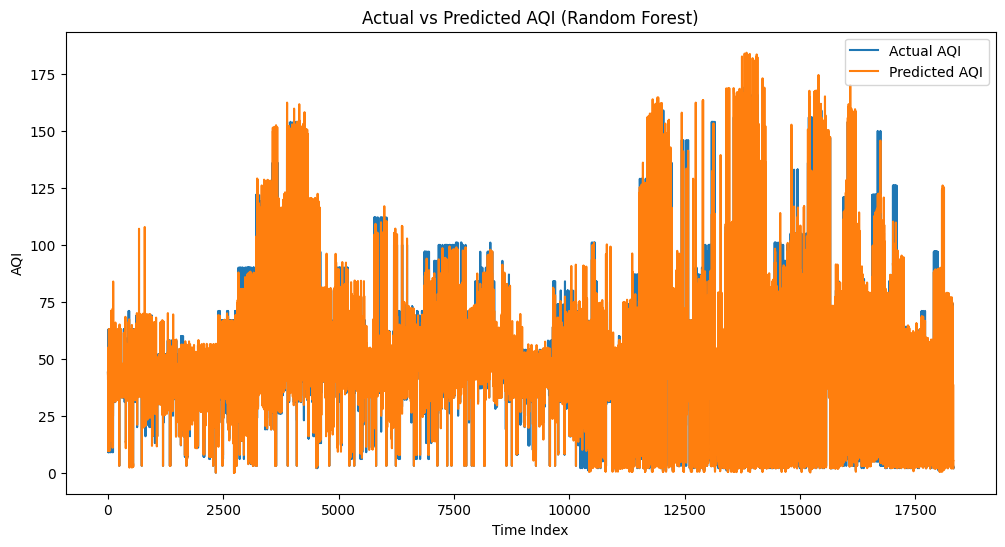

In [6]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title('Actual vs Predicted AQI (Random Forest)')
plt.xlabel('Time Index'); plt.ylabel('AQI'); plt.legend(); plt.show()


Gini Feature Importance (Top 15):
               Feature  Importance
11          AQI_roll_3    0.823112
22           dayofweek    0.117975
8            AQI_lag_1    0.022276
24           dayofyear    0.014726
9            AQI_lag_3    0.009680
6          Temperature    0.004240
23          is_weekend    0.002087
12          AQI_roll_7    0.000894
10           AQI_lag_7    0.000478
3                   O3    0.000423
25           PM25xTemp    0.000412
7        WindResultant    0.000410
26            NO2xWind    0.000409
5   BarometricPressure    0.000355
4                 PM25    0.000333


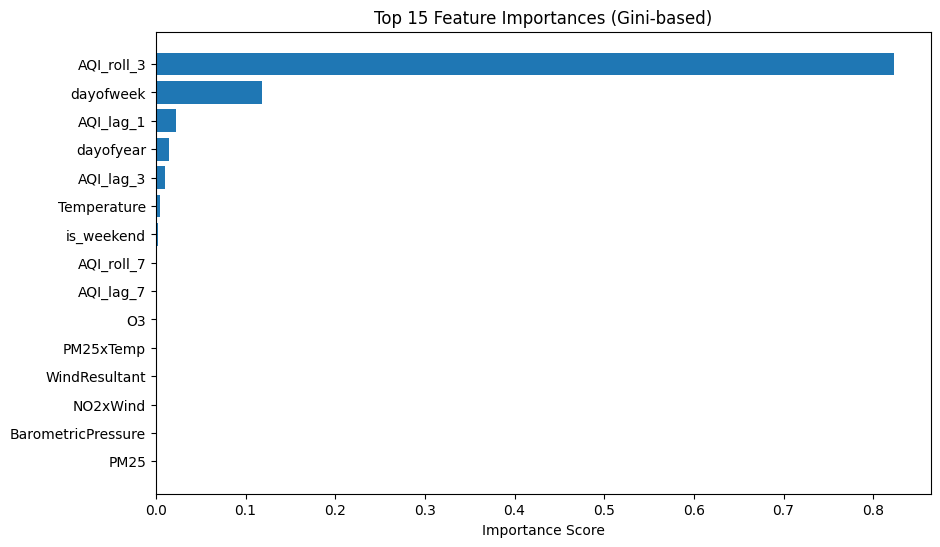

In [7]:
# 1. Gini importance
gini_importance = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nGini Feature Importance (Top 15):")
print(gini_importance.head(15))

plt.figure(figsize=(10,6))
plt.barh(gini_importance['Feature'][:15], gini_importance['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Gini-based)")
plt.xlabel("Importance Score")
plt.show()


/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Permutation Importance (Top 15):
          Feature  Importance
11     AQI_roll_3    4.985143
8       AQI_lag_1    0.914940
9       AQI_lag_3    0.049466
22      dayofweek    0.000964
10      AQI_lag_7    0.000879
4            PM25    0.000579
3              O3    0.000411
17    PM25_roll_3    0.000390
25      PM25xTemp    0.000309
18    PM25_roll_7    0.000123
13      CO_roll_3    0.000089
15     NO2_roll_3    0.000062
7   WindResultant    0.000046
0              CO    0.000034
16     NO2_roll_7    0.000020


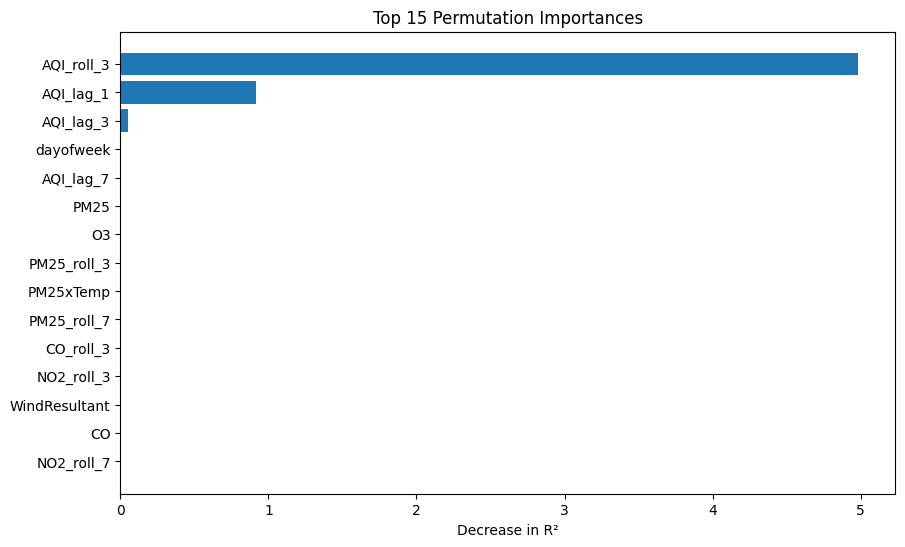

In [8]:
# 2. Permutation importance
perm_results = permutation_importance(
    rf_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1
)
perm_importance = pd.DataFrame({
    'Feature': FEATURES,
    'Importance': perm_results.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nPermutation Importance (Top 15):")
print(perm_importance.head(15))

plt.figure(figsize=(10,6))
plt.barh(perm_importance['Feature'][:15], perm_importance['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Permutation Importances")
plt.xlabel("Decrease in R²")
plt.show()

In [9]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=FEATURES,
    mode='regression'
)

i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test.values[i],
    predict_fn=rf_model.predict,
    num_features=10
)

try:
    exp.show_in_notebook(show_table=True)
except Exception:
    display(HTML(exp.as_html()))

with open("exp10_lime_explanation.html", "w") as f:
    f.write(exp.as_html())


/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


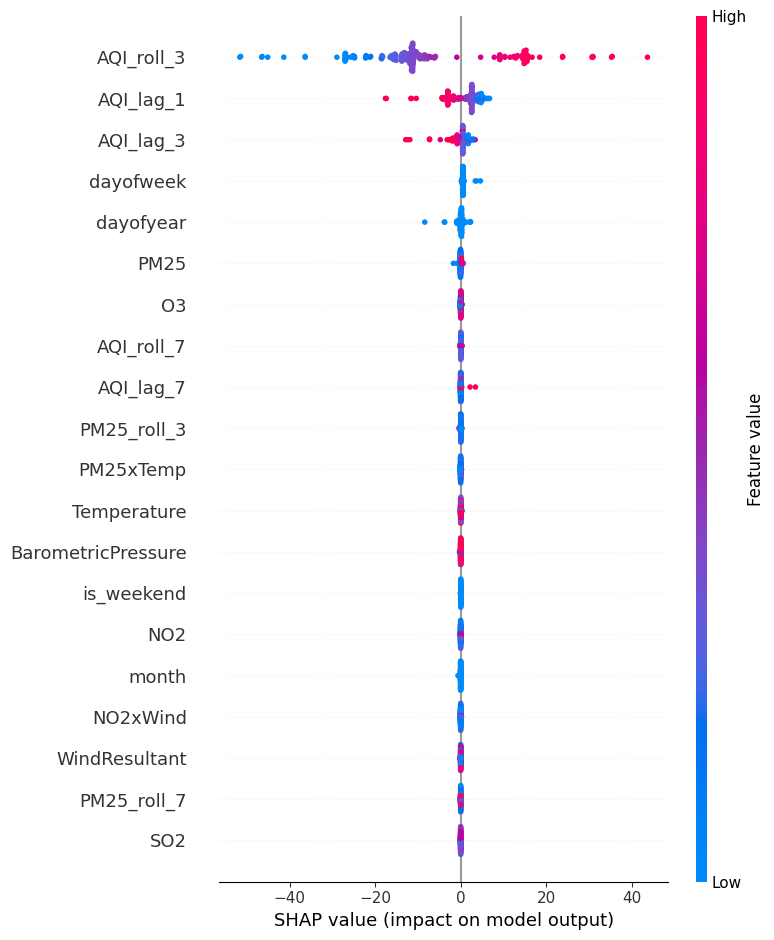

In [10]:
shap_explainer = shap.TreeExplainer(rf_model)
shap_values = shap_explainer.shap_values(X_test[:200])

shap.summary_plot(shap_values, X_test[:200], feature_names=FEATURES)